# Appendix G: LZSM Numerics



## Fig 16: effective vs RWA model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
import sys
sys.path.append('../common_scripts')
from floquet_system_st import floquet_system, SpatioTemporalNoise
from pathlib import Path
figures_path = Path().resolve().parent / 'figures'
# Parameters (similar to existing notebook)
det = 0
Vr = 2 * np.pi * 0.004
ddom = 2 * np.pi * 1e-3 * 0.4
Ldot = 20  # Dot size
x0 = 100   # Shuttling amplitude
v = 10     # Velocity
wc = 2 * np.pi * v / x0  # Conveyor frequency
dom = ddom * x0
wr = 1

# Period
T = 2 * np.pi / wc
print(f"Period T = {T:.2f}")

# Noise parameters
sigma = 0.02  # Noise amplitude
xc = 100    # Spatial correlation length

# Two cases to compare
tauc_quasistatic = 2000 # tauc >> T (quasistatic)
tauc_fast = 200                # tauc ~ T (fast noise)

print(f"\nCase 1: tauc = {tauc_quasistatic:.2f} (tauc/T = {tauc_quasistatic/T:.1f})")
print(f"Case 2: tauc = {tauc_fast:.2f} (tauc/T = {tauc_fast/T:.1f})")


Period T = 10.00

Case 1: tauc = 2000.00 (tauc/T = 200.0)
Case 2: tauc = 200.00 (tauc/T = 20.0)


In [2]:
# Generate spatio-temporal noise fields
# Domain size: need to cover trajectory and time range
# We'll simulate for t_total periods, so need domain >= t_total * T
t_total_sim = 50  # Expected simulation time in periods (will be set in simulation cell)
Lx = 3 * x0  # Spatial domain (covers -x0 to x0 with margin)
Lt = 1.5 * t_total_sim * T  # Time domain (150% of simulation time to avoid edge effects)

# Grid resolution
nx = 512  # Spatial grid points
nt = 2048  # Time grid points

print("Generating noise fields...")
print(f"Spatial domain: [-{Lx/2:.0f}, {Lx/2:.0f}], {nx} points")
print(f"Time domain: [0, {Lt:.2f}], {nt} points")
print(f"This covers {Lt/T:.1f} periods (simulation will use ~{t_total_sim} periods)")

# Case 1: Quasistatic (tauc >> T)
noise_quasistatic = SpatioTemporalNoise(
    nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
    Lx=Lx, Lt=Lt, sigma=sigma, seed=42
)

# Case 2: Fast noise (tauc ~ T)
noise_fast = SpatioTemporalNoise(
    nx=nx, nt=nt, xc=xc, tc=tauc_fast,
    Lx=Lx, Lt=Lt, sigma=sigma, seed=42
)

print("Done!")


Generating noise fields...
Spatial domain: [-150, 150], 512 points
Time domain: [0, 750.00], 2048 points
This covers 75.0 periods (simulation will use ~50 periods)
Done!


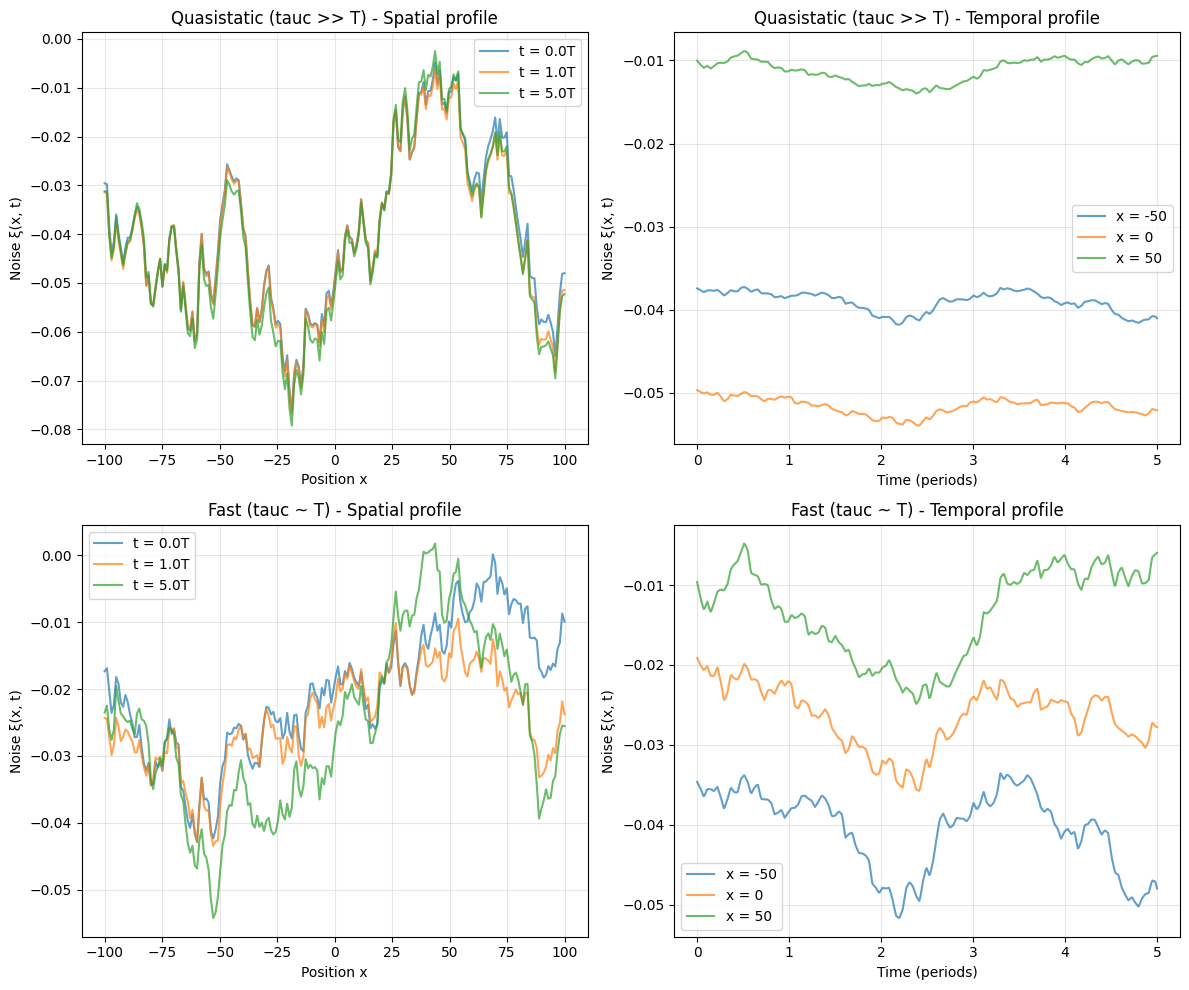

In [3]:
# Removed: diagnostic visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot spatial slices at different times
times_slice = [0, T, 5*T]
x_plot = np.linspace(-x0, x0, 200)

for i, (noise, label) in enumerate([(noise_quasistatic, "Quasistatic (tauc >> T)"),
                                     (noise_fast, "Fast (tauc ~ T)")]):
    ax1, ax2 = axes[i, 0], axes[i, 1]
    
    # Spatial slice at different times
    for t in times_slice:
        xi_vals = noise.get_xi(x_plot, t)
        ax1.plot(x_plot, xi_vals, label=f't = {t/T:.1f}T', alpha=0.7)
    ax1.set_xlabel('Position x')
    ax1.set_ylabel('Noise ξ(x, t)')
    ax1.set_title(f'{label} - Spatial profile')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Temporal slice at different positions
    t_plot = np.linspace(0, 5*T, 500)
    for x in [-x0/2, 0, x0/2]:
        xi_vals = noise.get_xi(x, t_plot)
        ax2.plot(t_plot/T, xi_vals, label=f'x = {x:.0f}', alpha=0.7)
    ax2.set_xlabel('Time (periods)')
    ax2.set_ylabel('Noise ξ(x, t)')
    ax2.set_title(f'{label} - Temporal profile')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [4]:
# Sweep over x0 and create colorplots
from tqdm import tqdm

# Parameters for sweep
x0_min, x0_max = 30, 220
n_x0 = 35
x0s = np.linspace(x0_min, x0_max, n_x0)

# Simulation parameters - constant absolute time
tmax = 1500  # Total time in absolute units (not periods)
dt = 0.2     # Time step in absolute units
Ntraj = 200   # Number of trajectories

# Storage for results: [case][model][x0_index] -> (times, probs)
results_sweep = {
    'quasistatic': {'RWA': [], 'effective': []},
    'fast': {'RWA': [], 'effective': []},
    'clean': {'RWA': [], 'effective': []}
}

print("Running x0 sweep...")
print(f"x0 values: {x0s}")

for x0 in tqdm(x0s):
    # Update wc based on x0 (keeping v constant)
    wc = 2 * np.pi * v / x0
    dom = ddom * x0
    T = 2 * np.pi / wc  # Period for current x0
    
    # Convert absolute time to periods for this x0
    t_T = tmax / T  # Total time in periods
    dt_T = dt / T   # Time step in periods
    
    # Update spatial domain if needed
    Lx_new = 3 * x0
    if Lx_new > Lx:
        Lx = Lx_new
        # Regenerate noise fields with larger spatial domain
        noise_quasistatic = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
        noise_fast = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_fast,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
    
    # Update time domain if needed (to cover tmax)
    if tmax > Lt:
        Lt = 1.5 * tmax  # 150% margin
        # Regenerate noise fields with larger time domain
        noise_quasistatic = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
        noise_fast = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_fast,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
    
    # Run for both noise cases
    for case_name, noise in [("quasistatic", noise_quasistatic), 
                              ("fast", noise_fast)]:
        # Create system with current x0
        system = floquet_system(
            det=det, Vr=Vr, wc=wc, dom=dom, wr=wr,
            Ldot=Ldot, x0=x0, phi0=0,
            spatio_temporal_noise=noise
        )
        
        # Run RWA model (t_T and dt_T are in periods, but result is in absolute time)
        times_rwa, probs_rwa, _ = system.avg_trajectories(
            t_T, dt_T, Ntraj, model='RWA'
        )
        results_sweep[case_name]['RWA'].append((times_rwa, probs_rwa))
        
        # Run effective model
        times_eff, probs_eff, _ = system.avg_trajectories(
            t_T, dt_T, Ntraj, model='effective'
        )
        results_sweep[case_name]['effective'].append((times_eff, probs_eff))
    
    # Run clean case (no noise) - single trajectory is enough
    system_clean = floquet_system(
        det=det, Vr=Vr, wc=wc, dom=dom, wr=wr,
        Ldot=Ldot, x0=x0, phi0=0,
        spatio_temporal_noise=None  # No noise
    )
    
    # Run RWA model (clean)
    times_rwa_clean, probs_rwa_clean, _ = system_clean.avg_trajectories(
        t_T, dt_T, 1, model='RWA'  # Single trajectory
    )
    results_sweep['clean']['RWA'].append((times_rwa_clean, probs_rwa_clean))
    
    # Run effective model (clean)
    times_eff_clean, probs_eff_clean, _ = system_clean.avg_trajectories(
        t_T, dt_T, 1, model='effective'  # Single trajectory
    )
    results_sweep['clean']['effective'].append((times_eff_clean, probs_eff_clean))

print("\nDone!")


Running x0 sweep...
x0 values: [ 30.          35.58823529  41.17647059  46.76470588  52.35294118
  57.94117647  63.52941176  69.11764706  74.70588235  80.29411765
  85.88235294  91.47058824  97.05882353 102.64705882 108.23529412
 113.82352941 119.41176471 125.         130.58823529 136.17647059
 141.76470588 147.35294118 152.94117647 158.52941176 164.11764706
 169.70588235 175.29411765 180.88235294 186.47058824 192.05882353
 197.64705882 203.23529412 208.82352941 214.41176471 220.        ]


100%|██████████| 35/35 [07:58<00:00, 13.66s/it]


Done!


## Saving processed data

In [ ]:
import os
import json

# Ensure the output directory exists
output_dir = os.path.join('../processed_data', 'fig16')
os.makedirs(output_dir, exist_ok=True)

# Save results_sweep as a JSON file
output_path = os.path.join(output_dir, 'data.json')

# Use a custom encoder to handle numpy arrays, if present
def convert(o):
    if hasattr(o, 'tolist'):
        return o.tolist()
    return o

with open(output_path, 'w') as f:
    json.dump(results_sweep, f, default=convert)

# Also save x0s in the same output directory for future reference
x0s_output_path = os.path.join(output_dir, 'x0s.json')
with open(x0s_output_path, 'w') as f:
    json.dump([float(x0) for x0 in x0s], f)
